In [ ]:
import pandas as pd
import re
import os
from html import unescape
import matplotlib.pyplot as plt

In [4]:
# Read the two TSV files (tab-separated values)
train_path = "../data/drugsComTrain_raw.tsv"
test_path  = "../data/drugsComTest_raw.tsv"

df_train = pd.read_csv(train_path, sep="\t")
df_test  = pd.read_csv(test_path,  sep="\t")

print(f"Train shape: {df_train.shape[0]:,} rows × {df_train.shape[1]} columns")
print(f"Test shape : {df_test.shape[0]:,} rows × {df_test.shape[1]} columns")

Train shape: 161,297 rows × 7 columns
Test shape : 53,766 rows × 7 columns


In [ ]:
# Define a tiny text cleaner
# Goal: keep text meaning intact, just fix HTML entities and messy whitespace.
_ws = re.compile(r"\s+")  # matches any run of whitespace (spaces, tabs, newlines)

def clean_text(x: str):
    """
    Convert HTML entities and normalize whitespace.
    - Leaves casing and punctuation unchanged (useful for sentiment).
    - Returns NaN unchanged for safety.
    """
    if pd.isna(x):
        return x
    # 1) Convert HTML entities 
    s = unescape(x)
    # 2) Replace non-breaking spaces (U+00A0) with normal spaces
    s = s.replace("\u00A0", " ")
    # 3) Collapse repeated whitespace/newlines into single spaces, and trim ends
    s = _ws.sub(" ", s).strip()
    return s

In [11]:
# Create a cleaned text column on both splits
# keep the original 'review' for traceability, and add 'review_clean' for modeling/EDA.
df_train["review_clean"] = df_train["review"].map(clean_text)
df_test["review_clean"]  = df_test["review"].map(clean_text)

# Show original vs cleaned side by side for a quick spot check
#df_test[["review", "review_clean"]].head(9)

os.makedirs("../data/processed", exist_ok=True)

# Columns to include in the saved files (original + cleaned, plus context)
cols = ["drugName", "condition", "review", "review_clean", "rating", "date", "usefulCount"]

# Save FULL cleaned train/test as TSV (tab-separated, UTF-8, no row index)
df_train[cols].to_csv("../data/processed/drugsComTrain_clean.tsv", sep="\t", index=False, encoding="utf-8")
df_test[cols].to_csv("../data/processed/drugsComTest_clean.tsv",  sep="\t", index=False, encoding="utf-8")

In [13]:
# Count missing values in key columns
print("Missing in train:")
print(df_train[["review_clean", "rating"]].isna().sum(), "\n")

print("Missing in test:")
print(df_test[["review_clean", "rating"]].isna().sum())


Missing in train:
review_clean    0
rating          0
dtype: int64 

Missing in test:
review_clean    0
rating          0
dtype: int64


count    161297.000000
mean        447.807362
std         235.819653
min           3.000000
25%         256.000000
50%         445.000000
75%         675.000000
max       10386.000000
Name: len_chars, dtype: float64


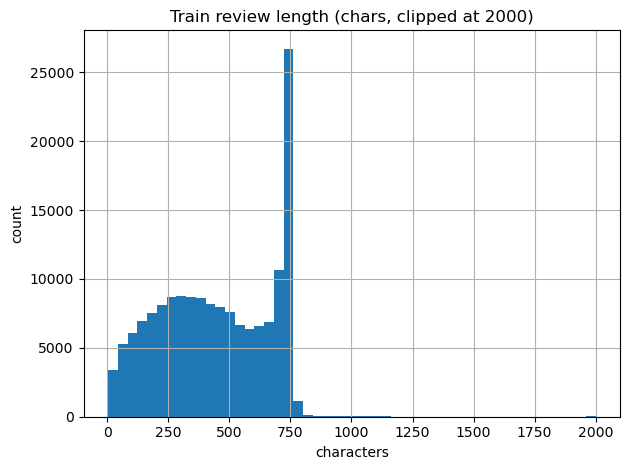

In [ ]:

# Add a length column (number of characters) for quick sanity
df_train["len_chars"] = df_train["review_clean"].str.len()

print(df_train["len_chars"].describe())  # min/median/mean/max

# Simple histogram of review lengths (trim very long texts for visibility)
_ = df_train["len_chars"].clip(upper=2000).hist(bins=50)
plt.title("Train review length (chars, clipped at 2000)")
plt.xlabel("characters")
plt.ylabel("count")
plt.tight_layout()
plt.show()

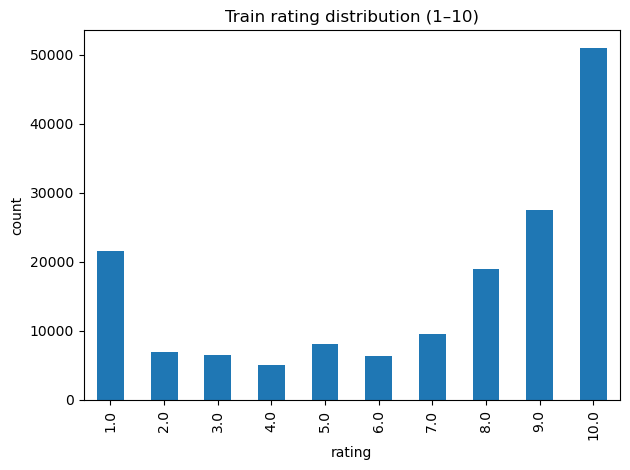

In [ ]:
# Rating distribution (reflects class balance)
ax = df_train["rating"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Train rating distribution (1–10)")
ax.set_xlabel("rating")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()